In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import mmread, mmwrite

In [2]:
projdir = '/u/home/t/terencew/project-cluo/demux_benchmark/adelus_2023/'
donors = list(np.loadtxt(f'{projdir}/txt/donors.txt', dtype=str))
samples = list(np.loadtxt(f'{projdir}/txt/samples.txt', dtype=str))
new_samples = [x.replace('MT_', 'MT-').replace('pooled_','pooled-') for x in samples]
s = samples[0]

gex_methods = ['demuxlet', 'freemuxlet', 'vireo', 'vireo_nogenos',
               'scsplit', 'scsplit_nogenos',
            'souporcell', 'souporcell_nogenos', 'demuxalot']
atac_methods = ['demuxlet', 'freemuxlet', 'vireo', 'vireo_nogenos',
               'scsplit', 'scsplit_nogenos',
            'souporcell', 'souporcell_nogenos', 'scavengers']

con_cols = ['C1', 'C2', 'I1', 'I2']

In [3]:
gex_sings = pd.read_csv(f'{projdir}/csv/demux/singlet_gex.csv', sep='\t',
                  header=0, index_col=0)
atac_sings = pd.read_csv(f'{projdir}/csv/demux/singlet_atac.csv', sep='\t',
                   header=0, index_col=0)
gex_sings.replace({'doublet' : 'non_singlet' , 'unassigned' : 'non_singlet'}, inplace=True)
atac_sings.replace({'doublet' : 'non_singlet' , 'unassigned' : 'non_singlet'}, inplace=True)

tmp_gex_sings = gex_sings.copy()
tmp_atac_sings = atac_sings.copy()
tmp_gex_sings['inter'] = gex_sings.eq(gex_sings.iloc[:, 0], axis=0).all(1)
tmp_atac_sings['inter'] = atac_sings.eq(atac_sings.iloc[:, 0], axis=0).all(1)
gex_sings['inter'] = tmp_gex_sings['inter']
atac_sings['inter'] = tmp_atac_sings['inter']
gex_sings.shape, atac_sings.shape

((35201, 10), (35201, 10))

In [4]:
tmp_gex_sings = gex_sings.iloc[:,:-1]
tmp_gex_sings.columns = [f'gex_{x}' for x in tmp_gex_sings.columns]
tmp_atac_sings = atac_sings.iloc[:,:-1]
tmp_atac_sings.columns = [f'atac_{x}' for x in tmp_atac_sings.columns]
 
merged_sings = pd.concat([tmp_gex_sings, tmp_atac_sings], axis=1)
merged_sings['inter'] = merged_sings.eq(merged_sings.iloc[:, 0], axis=0).all(1)

In [5]:
sum(gex_sings['inter']), sum(atac_sings['inter']), sum(merged_sings['inter'])

(19607, 25088, 16176)

In [8]:
gex = pd.read_csv(f'{projdir}/csv/demux/inter_gex.csv', sep='\t',
                  header=0, index_col=0)
atac = pd.read_csv(f'{projdir}/csv/demux/inter_atac.csv', sep='\t',
                   header=0, index_col=0)
gex.replace({'doublet' : 'non_singlet' , 'unassigned' : 'non_singlet'}, inplace=True)
atac.replace({'doublet' : 'non_singlet' , 'unassigned' : 'non_singlet'}, inplace=True)

gex.index = [x.replace('MT_', 'MT-').replace('pooled_', 'pooled-') for x in gex.index]
atac.index = [x.replace('MT_', 'MT-').replace('pooled_', 'pooled-') for x in atac.index]

gex.shape, atac.shape

((35201, 9), (35201, 9))

In [9]:
tmp_gex = gex.copy()
tmp_atac = atac.copy()
tmp_gex['inter'] = gex.eq(gex.iloc[:, 0], axis=0).all(1)
tmp_atac['inter'] = atac.eq(atac.iloc[:, 0], axis=0).all(1)
tmp_gex['majority'] = gex.mode(axis=1)[0]
tmp_atac['majority'] = atac.mode(axis=1)[0]

gex['majority'] = tmp_gex['majority']
atac['majority'] = tmp_atac['majority']

gex['inter'] = tmp_gex['inter']
atac['inter'] = tmp_atac['inter']

# gex_inter = pd.DataFrame(tmp_gex[tmp_gex['inter']]['demuxlet'])
# gex_inter.columns = ['inter']

# atac_inter = pd.DataFrame(tmp_atac[tmp_atac['inter']]['demuxlet'])
# atac_inter.columns = ['inter']

gex.shape, atac.shape

((35201, 11), (35201, 11))

In [10]:
gex_mask = ~gex['inter']
unique_gex = gex[gex_mask]

atac_mask = ~atac['inter']
unique_atac = atac[atac_mask]
unique_gex.shape, unique_atac.shape

((20033, 11), (14414, 11))

In [11]:
def process_con(con):
    con['DP'] = np.sum(con.iloc[:,:4], axis=1)
    con['Consistent rate'] = (con['C1'] + con['C2']) / con['DP']
    con['Inconsistent rate'] = 1 - con['Consistent rate']
    con['C1 rate'] = con['C1'] / con['DP']
    con['C2 rate'] = con['C2'] / con['DP']
    con['I1 rate'] = con['I1'] / con['DP']
    con['I2 rate'] = con['I2'] / con['DP']
    return con

In [15]:
tmp_cols = con_cols + ['n_drops']
cov = 20
condir = f'{projdir}/csv/var_consistency/gex/merged/'
all_con_gex = pd.DataFrame(index=gex_methods, columns=tmp_cols, data=0)
for method in gex_methods:
    mask = unique_gex[method] != 'non_singlet'
    method_con = pd.read_csv(f'{condir}/{method}_cov{cov}_varcon.csv', sep='\t', header=0, index_col=0)
    method_gex = unique_gex[mask]
    mask = method_con.index.isin(method_gex.index)
    method_con = method_con[mask]
    method_con = pd.DataFrame(method_con.sum(axis=0)[:4]).transpose()
    all_con_gex.loc[method] = list(method_con.iloc[0]) + [method_gex.shape[0]]
    print(method, method_gex.shape[0])

demuxlet 9823
freemuxlet 19948
vireo 15007
vireo_nogenos 16409
scsplit 16351
scsplit_nogenos 16177
souporcell 17365
souporcell_nogenos 17282
demuxalot 14168


In [16]:
tmp_cols = con_cols + ['n_drops']
cov = 20
condir = f'{projdir}/csv/var_consistency/atac/merged/'
all_con_atac = pd.DataFrame(index=atac_methods, columns=tmp_cols, data=0)
for method in atac_methods:
    mask = unique_atac[method] != 'non_singlet'
    method_con = pd.read_csv(f'{condir}/{method}_cov{cov}_varcon.csv', sep='\t', header=0, index_col=0)
    method_atac = unique_atac[mask]
    mask = method_con.index.isin(method_atac.index)
    method_con = method_con[mask]
    method_con = pd.DataFrame(method_con.sum(axis=0)[:4]).transpose()
    all_con_atac.loc[method] = list(method_con.iloc[0]) + [method_atac.shape[0]]
    print(method, method_atac.shape[0])

demuxlet 8443
freemuxlet 14382
vireo 10084
vireo_nogenos 10137
scsplit 12121
scsplit_nogenos 12271
souporcell 10676
souporcell_nogenos 12208
scavengers 11269


In [19]:
### this is just singlets called by that method, I think this is fine!

tmp_cols = con_cols + ['n_drops']
cov = 20
condir = f'{projdir}/csv/var_consistency/gex/merged/'
all_con_gex = pd.DataFrame(index=gex_methods, columns=tmp_cols, data=0)
for method in gex_methods:
    mask = unique_gex[method] != 'non_singlet'
    method_con = pd.read_csv(f'{condir}/{method}_cov{cov}_varcon.csv', sep='\t', header=0, index_col=0)
    method_gex = unique_gex[mask]
    mask = method_con.index.isin(method_gex.index)
    method_con = method_con[mask]
    method_con = pd.DataFrame(method_con.sum(axis=0)[:4]).transpose()
    all_con_gex.loc[method] = list(method_con.iloc[0]) + [method_gex.shape[0]]
    
test_con_gex = all_con_gex.iloc[:,:4].div(all_con_gex['n_drops'], axis=0)
test_con_gex = process_con(test_con_gex)
test_con_gex

,C1,C2,I1,I2,DP,Consistent rate,Inconsistent rate,C1 rate,C2 rate,I1 rate,I2 rate
demuxlet,1.893719,77.449455,4.629645,0.056093,84.028912,0.944237,0.055763,0.022537,0.921700,0.055096,0.000668
freemuxlet,2.893674,172.982404,23.811510,0.277421,199.965009,0.879534,0.120466,0.014471,0.865063,0.119078,0.001387
vireo,1.871860,80.147531,5.223296,0.069834,87.312521,0.939377,0.060623,0.021439,0.917939,0.059823,0.000800
vireo_nogenos,2.023158,93.018648,7.493875,0.097934,102.633616,0.926030,0.073970,0.019712,0.906318,0.073016,0.000954
scsplit,2.128799,165.904715,31.831509,0.288178,200.153202,0.839524,0.160476,0.010636,0.828889,0.159036,0.001440
scsplit_nogenos,2.038882,162.668789,31.446869,0.278605,196.433146,0.838492,0.161508,0.010380,0.828113,0.160089,0.001418
souporcell,2.403916,124.157846,13.005989,0.163778,139.731529,0.905749,0.094251,0.017204,0.888546,0.093078,0.001172
souporcell_nogenos,2.409848,126.935829,13.905740,0.178220,143.429638,0.901806,0.098194,0.016802,0.885004,0.096952,0.001243
demuxalot,1.574887,63.630011,3.360672,0.041643,68.607213,0.950409,0.049591,0.022955,0.927454,0.048984,0.000607


In [21]:
### this is just singlets called by that method, I think this is fine!

tmp_cols = con_cols + ['n_drops']
cov = 20
condir = f'{projdir}/csv/var_consistency/atac/merged/'
all_con_atac = pd.DataFrame(index=atac_methods, columns=tmp_cols, data=0)
for method in atac_methods:
    mask = unique_atac[method] != 'non_singlet'
    method_con = pd.read_csv(f'{condir}/{method}_cov{cov}_varcon.csv', sep='\t', header=0, index_col=0)
    method_atac = unique_atac[mask]
    mask = method_con.index.isin(method_atac.index)
    method_con = method_con[mask]
    method_con = pd.DataFrame(method_con.sum(axis=0)[:4]).transpose()
    all_con_atac.loc[method] = list(method_con.iloc[0]) + [method_atac.shape[0]]

    
test_con_atac = all_con_atac.iloc[:,:4].div(all_con_atac['n_drops'], axis=0)
test_con_atac = process_con(test_con_atac)
test_con_atac

,C1,C2,I1,I2,DP,Consistent rate,Inconsistent rate,C1 rate,C2 rate,I1 rate,I2 rate
demuxlet,1.426862,62.293971,4.522326,0.085988,68.329148,0.932557,0.067443,0.020882,0.911675,0.066184,0.001258
freemuxlet,10.145738,625.441733,113.672577,2.472813,751.732861,0.845496,0.154504,0.013496,0.832000,0.151214,0.003289
vireo,2.721936,120.588457,11.462416,0.284808,135.057616,0.913021,0.086979,0.020154,0.892867,0.084871,0.002109
vireo_nogenos,3.603433,172.461774,19.814343,0.482391,196.361941,0.896636,0.103364,0.018351,0.878285,0.100907,0.002457
scsplit,9.885405,660.897203,135.562742,2.731045,809.076396,0.829072,0.170928,0.012218,0.816854,0.167552,0.003376
scsplit_nogenos,8.836281,647.854128,141.513895,2.604759,800.809062,0.820034,0.179966,0.011034,0.808999,0.176714,0.003253
souporcell,5.586456,393.316223,77.851161,1.720120,478.473960,0.833698,0.166302,0.011676,0.822022,0.162707,0.003595
souporcell_nogenos,4.748935,317.286288,58.554718,1.319299,381.909240,0.843224,0.156776,0.012435,0.830790,0.153321,0.003454
scavengers,4.893602,324.219097,61.839027,1.073387,392.025113,0.839519,0.160481,0.012483,0.827037,0.157743,0.002738


In [22]:
test_con_gex['method'] = [f'gex_{x}' for x in test_con_gex.index]
test_con_atac['method'] = [f'atac_{x}' for x in test_con_atac.index]

<AxesSubplot:xlabel='variable', ylabel='value'>

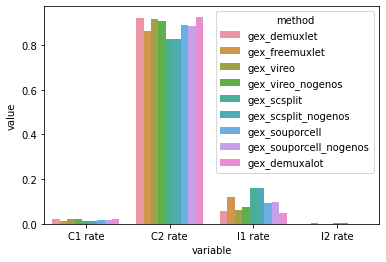

In [23]:
melt_cols = ['C1 rate', 'C2 rate', 'I1 rate', 'I2 rate']
gex_melt_con = test_con_gex.melt(id_vars='method', value_vars=melt_cols)
sns.barplot(gex_melt_con, x='variable', y='value', hue='method')

<AxesSubplot:xlabel='variable', ylabel='value'>

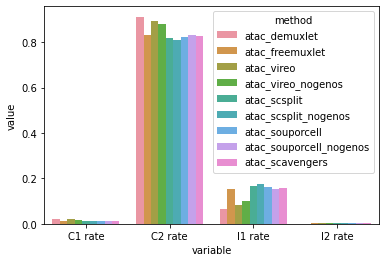

In [24]:
melt_cols = ['C1 rate', 'C2 rate', 'I1 rate', 'I2 rate']
atac_melt_con = test_con_atac.melt(id_vars='method', value_vars=melt_cols)
sns.barplot(atac_melt_con, x='variable', y='value', hue='method')

In [25]:
gex_melt_con['mod'] = 'gex'
atac_melt_con['mod'] = 'atac'

In [26]:
merged = pd.concat([gex_melt_con, atac_melt_con])
merged['method'] = [x.replace('gex_','').replace('atac_','') for x in merged['method']]

<AxesSubplot:xlabel='variable', ylabel='value'>

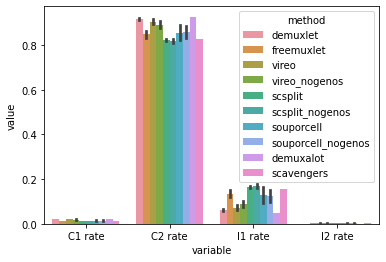

In [27]:
sns.barplot(merged, x='variable', y='value', hue='method')

In [28]:
# merged

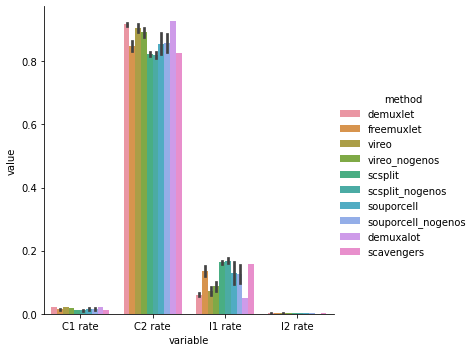

In [29]:
sns.catplot(merged, kind='bar', x='variable', y='value', hue='method')

# sns.catplot(
#     penguins, kind="bar",
#     x="sex", y="body_mass_g", col="species",
#     height=4, aspect=.5,
# )

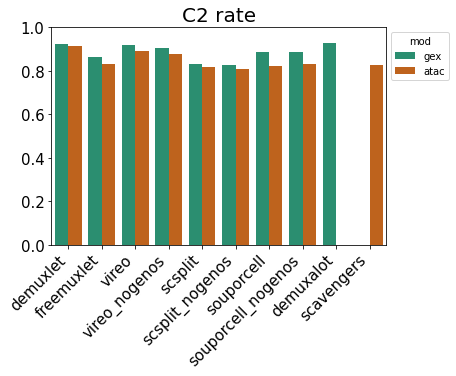

In [30]:
sns.set_palette('Dark2')

tmp_merged = merged[merged['variable'] == 'C2 rate']
ax = sns.barplot(tmp_merged, x='method', y='value', hue='mod')
ax.set_ylim(0, 1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=15,
                   horizontalalignment='right')
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title(f'C2 rate', fontsize=20)
# custom_ticks = np.linspace(0, 0.2, 5)
# ax.set_yticks(custom_ticks, fontsize=20)
ax.tick_params(axis='y', labelsize=15)  # Adjust the labelsize parameter as needed
ax.grid(False)

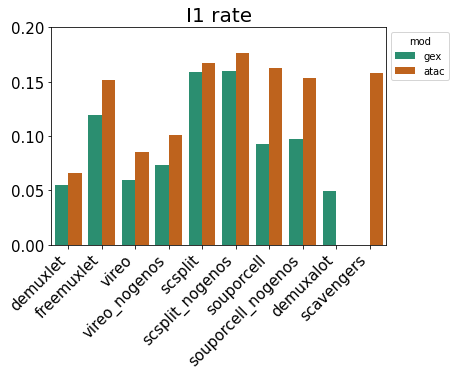

In [31]:
sns.set_palette('Dark2')

tmp_merged = merged[merged['variable'] == 'I1 rate']
ax = sns.barplot(tmp_merged, x='method', y='value', hue='mod')
ax.set_ylim(0, 0.2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=15,
                   horizontalalignment='right')
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title(f'I1 rate', fontsize=20)
custom_ticks = np.linspace(0, 0.2, 5)
ax.set_yticks(custom_ticks, fontsize=20)
ax.tick_params(axis='y', labelsize=15)  # Adjust the labelsize parameter as needed
ax.grid(False)

<AxesSubplot:xlabel='method', ylabel='value'>

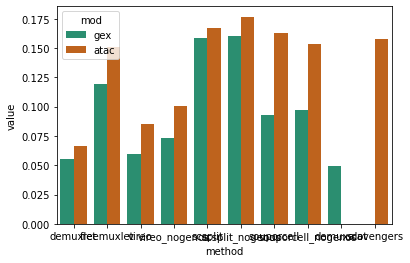

In [33]:
tmp_merged = merged[merged['variable'] == 'I1 rate']
sns.barplot(tmp_merged, x='method', y='value', hue='mod')

<AxesSubplot:xlabel='method', ylabel='value'>

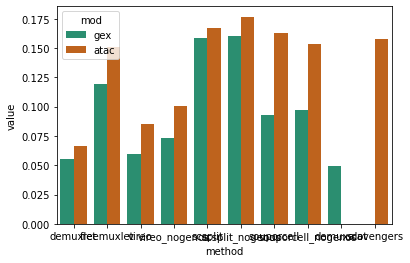

In [34]:
sns.barplot(tmp_merged, x='method', y='value', hue='mod')

Text(0.5, 0.98, 'Aorta dataset')

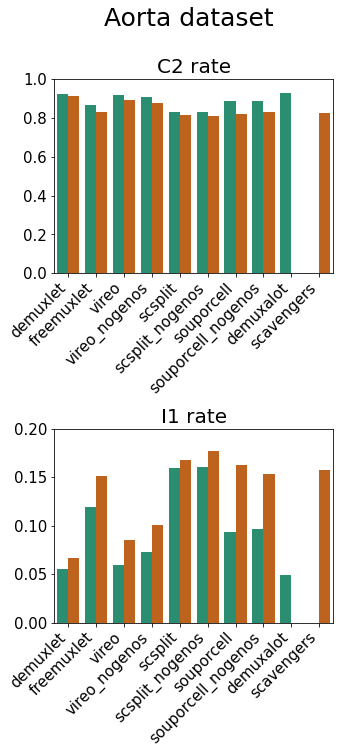

In [35]:
sns.set_palette('Dark2')
final_cols = ['C2 rate', 'I1 rate']

ylims = [1, 0.2]

fig, axes = plt.subplots(2, 1, figsize=(5, 10))

for i,ax in enumerate(axes.flatten()):
    col = final_cols[i]
    ylim = ylims[i]
    tmp_merged = merged[merged['variable'] == col]
    sns.barplot(tmp_merged, x='method', y='value', hue='mod', ax=ax)
    ax.set_ylim(0, ylim)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=15,
                       horizontalalignment='right')

    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(col, fontsize=20)
    ax.tick_params(axis='y', labelsize=15)  # Adjust the labelsize parameter as needed
    ax.grid(False)
    ax.legend_.set_visible(False)
    
plt.subplots_adjust(wspace=0.2, hspace=0.8)  # Adjust the value as needed
plt.suptitle('Aorta dataset', size=25)

In [37]:
merged.reset_index(drop=True, inplace=True)

In [41]:
merged.loc[73] = ['scavengers', 'C1 rate', 0, 'gex']
merged.loc[74] = ['scavengers', 'C2 rate', 0, 'gex']
merged.loc[75] = ['scavengers', 'I1 rate', 0, 'gex']
merged.loc[76] = ['scavengers', 'I2 rate', 0, 'gex']

In [42]:
merged.loc[77] = ['demuxalot', 'C1 rate', 0, 'atac']
merged.loc[78] = ['demuxalot', 'C2 rate', 0, 'atac']
merged.loc[79] = ['demuxalot', 'I1 rate', 0, 'atac']
merged.loc[80] = ['demuxalot', 'I2 rate', 0, 'atac']

In [43]:
merged.to_csv(f'{projdir}/csv/final_figures/figure6/figure_6b_avg_con_rates.csv', sep='\t', header=True, index=True)

In [44]:
merged

,method,variable,value,mod
0,demuxlet,C1 rate,0.022537,gex
1,freemuxlet,C1 rate,0.014471,gex
2,vireo,C1 rate,0.021439,gex
3,vireo_nogenos,C1 rate,0.019712,gex
4,scsplit,C1 rate,0.010636,gex
...,...,...,...,...
79,demuxalot,I1 rate,0.000000,atac
80,demuxalot,I2 rate,0.000000,atac
74,scavengers,C2 rate,0.000000,gex
75,scavengers,I1 rate,0.000000,gex
